In [ ]:
#from sklearn.utils.extmath import randomized_svd
#import of the main libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy 
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from scipy.linalg import interpolative

In [ ]:
# read arff data
arffData = np.load('bibtex_arr.npy')

In [ ]:
#checking data
np.unique(arffData)

array([0, 1])

In [ ]:
arffData = np.array(arffData).astype(np.int0)

In [ ]:
#density
(arffData > 0).sum() / (arffData.shape[0] * arffData.shape[1])

0.03562035582533074

In [ ]:
#check degrees
degrees_Instances = arffData.sum(axis = 1) # sum through rows

In [ ]:
degrees_Features = arffData.sum(axis = 0) # sum through cols

No handles with labels found to put in legend.


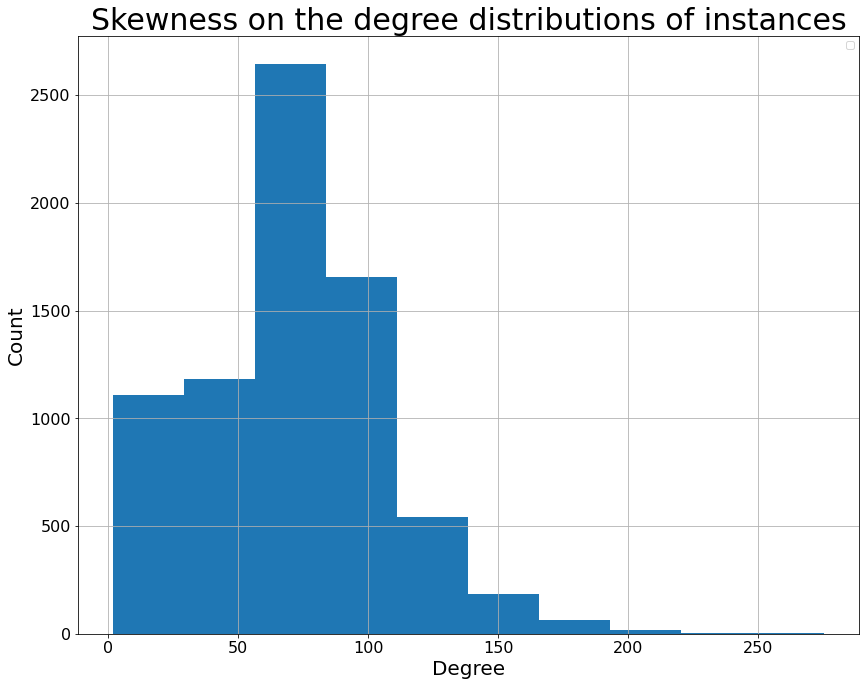

In [ ]:
#Showing of the skewness of data
fig, ax = plt.subplots(figsize = (14, 11))

plt.hist(degrees_Instances)

ax.set_xlabel('Degree', fontsize=20)
plt.xticks(fontsize=16)

ax.set_ylabel('Count', fontsize=20)
plt.yticks(fontsize=16)

plt.title('Skewness on the degree distributions of instances', fontsize=30)
plt.legend()
plt.grid()
plt.show();


No handles with labels found to put in legend.


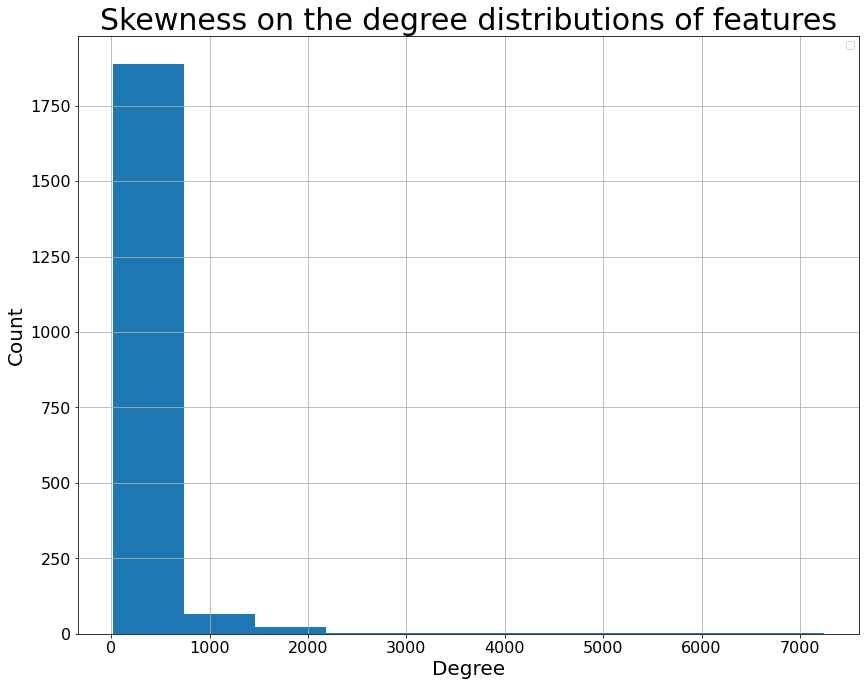

In [ ]:
#showing of the skewness of data
fig, ax = plt.subplots(figsize = (14, 11))

plt.hist(degrees_Features)

ax.set_xlabel('Degree', fontsize=20)
plt.xticks(fontsize=16)

ax.set_ylabel('Count', fontsize=20)
plt.yticks(fontsize=16)

plt.title('Skewness on the degree distributions of features', fontsize=30)
plt.legend()
plt.grid()
plt.show();


In [ ]:
#load of prepeared initial_matrix
initial = np.load('initial_matrix.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

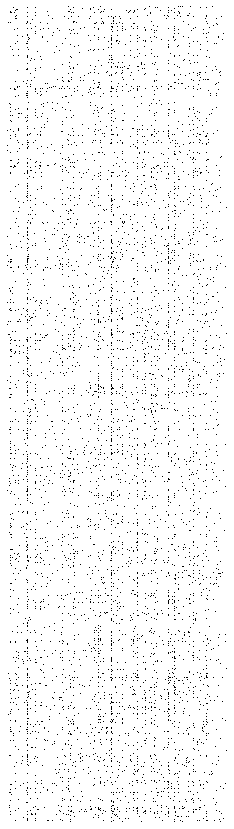

In [ ]:
#plot of structure of initial_matrix
fig, ax = plt.subplots(figsize = (10, 15))
plt.gca().set_aspect('equal', adjustable='box')

plt.spy(initial.astype(np.int8))
plt.axis('scaled')
plt.axis('off')
plt.draw()
from google.colab import files
# plt.savefig('initial.png', dpi=300)
# files.download("initial.png") 

In [ ]:
#load of prepeared reordered_matrix
reordered = np.load('reorded.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

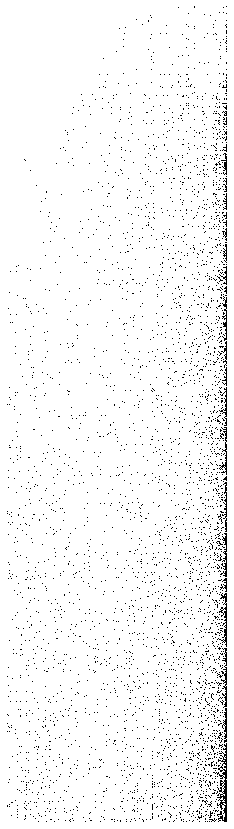

In [ ]:
#plot of the structure of reordered_matrix
fig, ax = plt.subplots(figsize = (10, 15))
plt.gca().set_aspect('equal', adjustable='box')

plt.spy(reordered.astype(np.int8))
plt.axis('scaled')
plt.axis('off')
plt.draw()
from google.colab import files
plt.savefig('initial.png', dpi=300)
files.download("initial.png") 

In [ ]:
matrix = arffData.copy()

In [ ]:
np.save("bibtex_arr",matrix)

In [ ]:
def pinv(matrix,alpha):
  #function to compress our matrix
  def compress(matrix, k, n_iter, max_row, max_col, min_row = 0, min_col = 0):
    if(n_iter == 0 or min_row + 10 > max_row or min_col + 10 > max_col):
        return matrix, min_row,min_col
    
    new_n_iter = n_iter - 1
    #searching hubs
    matrix_inst_degr = matrix[min_row:max_row,min_col:max_col].sum(axis = 1)
    matrix_feat_degr = matrix[min_row:max_row,min_col:max_col].sum(axis = 0)
    n_max_inst = int(np.floor(matrix[min_row:max_row,min_col:max_col].shape[0]*k))
    n_max_feat = int(np.floor(matrix[min_row:max_row,min_col:max_col].shape[1]*k))
    ids_feat = matrix_feat_degr.argsort()[-n_max_feat:][::-1] + min_col
    ids_inst = matrix_inst_degr.argsort()[-n_max_inst:][::-1] + min_row
    #moving hubs
    for ind in range(1,n_max_inst+1):
        matrix[[-ind + max_row,ids_inst[ind - 1]]] = matrix[[ids_inst[ind -1],-ind + max_row]]
    for ind in range(1,n_max_feat+1):
        matrix[:,[-ind + max_col,ids_feat[ind - 1]]] = matrix[:,[ids_feat[ind - 1],-ind + max_col]]
    #creating graph
    size_sparse = tuple(np.array([ - min_row + max_row - n_max_inst, - min_col + max_col - n_max_feat]))
    adjencity = np.zeros((size_sparse[0] + size_sparse[1],size_sparse[0] + size_sparse[1]))
    adjencity[-size_sparse[0]:,:size_sparse[1]] = matrix[min_row:min_row + size_sparse[0],min_col:min_col + size_sparse[1]]
    adjencity[:size_sparse[1],-size_sparse[0]:] = (matrix[min_row:min_row + size_sparse[0],min_col:min_col + size_sparse[1]]).T
    g = nx.Graph(adjencity)
    #searching connected components
    components = sorted(nx.connected_components(g), key=len, reverse=False)
    dict_feat = [(i) for i in range(size_sparse[1])]
    dict_inst = [(i) for i in range(size_sparse[0])]
    counter_row = min_row
    counter_col = min_col
    comp_n = 0
    #moving spokes
    for comp in components[:-1]:
        comp_n += 1
        comp_l = list(comp)
        for node in comp_l:
            if(node >= size_sparse[1]):
                ind = dict_inst[node - size_sparse[1]]
                dict_inst[counter_row - min_row] = ind
                matrix[[ind + min_row,counter_row]] = matrix[[counter_row,ind + min_row]]
                counter_row += 1
            else:
                ind = dict_feat[node]
                dict_feat[counter_col - min_col] = ind
                matrix[:,[ind + min_col,counter_col]] = matrix[:,[counter_col,ind + min_col]]
                counter_col += 1
    new_min_row = counter_row
    new_min_col = counter_col
    new_max_row = max_row -n_max_inst
    new_max_col = max_col -n_max_feat
    #repeat algorithm for GCC
    return compress(matrix,k,new_n_iter,new_max_row,new_max_col,new_min_row,new_min_col)

  #we get compressed matrix
  res = compress(matrix, 0.05, 200, matrix.shape[0], matrix.shape[1])

  #define alpha level, alpha - target rank ration
  alpha = alpha
  #transform our compressed matrix in sparse type
  A = scipy.sparse.csr_matrix(res[0])
  A_ = res[0]
  A11 = scipy.sparse.csr_matrix(A_[:res[2], :res[1]])
  A11 = A11.asfptype()
  A21 = scipy.sparse.csr_matrix(A_[res[2]:, :res[1]])
  A21 = A21.asfptype()

  #ss=alpha*n1 - traget rank for A11 factorisation
  ss = int(alpha * res[1])
  #Final decomposition of A11, complition of step 2
  u, z, vt = scipy.sparse.linalg.svds(A11, k=ss)

  #matrix [sigma & v^t // A21] - right matrix of step 3 of [A11 // A21] decomposition
  matrix_2 = scipy.sparse.csr_matrix(scipy.sparse.vstack(
    (scipy.sparse.diags(z) @ vt, A21))
          )
  #Approximation of right matrix, sigma and vt are also parts of final decomposition of [A11 // A21]
  u_s_m2, z_s_s, vt_s_n1 = scipy.sparse.linalg.svds(matrix_2, k=ss)
  #Left matrix of step 3
  U_O_O_I = scipy.sparse.block_diag((u, scipy.sparse.eye(A.shape[0] - u.shape[0])))
  #U for svd factorisation of matrix [A11 // A21]
  U = U_O_O_I @ u_s_m2

  #traget rank for A factorisation
  r = int(alpha * A.shape[1])
  #matrix [A12 // A22]
  A__ = scipy.sparse.csr_matrix(A_[:,res[1]:])
  #Left matrix
  matrix_1 = scipy.sparse.hstack((U @ scipy.sparse.diags(z_s_s), A__))
  #Lefr matrix low rank approximation
  u_m_r, z_r_r, vt_r_sn2 = scipy.sparse.linalg.svds(matrix_1, k=r)
  #Final vt
  VT = vt_r_sn2 @ scipy.sparse.block_diag((vt_s_n1, scipy.sparse.eye(A.shape[1] - vt_s_n1.shape[1])))
  #Below lines are committed, due to the fact that they return pseudoinverse matrix
  #but to evaluate metrics we need only factorisation
  #z_r_r = np.ones(z_r_r.shape[0]) / z_r_r
  #return VT.transpose() @ scipy.sparse.diags(z_r_r) @ u_m_r.transpose()
  return u_m_r @ scipy.sparse.diags(z_r_r) @ VT





In [ ]:
#This cell works to evaluate time and reconstruction error of getting solution with FastPI method
time = []
error = []
for i in np.arange(0.01, 0.15, 0.02):
  t = %timeit -n1 -r1 -o (pinv(arffData.copy(), i))
  time.append(np.mean(t.all_runs))
  e = pinv(arffData.copy(), i)
  error.append(scipy.linalg.norm(e - arffData, 'fro'))


In [ ]:
#function to get factorisation with default scipy method
def p(mat, alpha):
  kk = int(alpha * mat.shape[1])
  mat = (scipy.sparse.csr_matrix(mat))
  mat = mat.asfptype()
  u, z, vt = scipy.sparse.linalg.svds(mat, k=kk)
  #zz = np.ones(z.shape[0]) / z
  return u @ scipy.sparse.diags(z) @ vt

In [ ]:
#This cell works to evaluate time and reconstruction error of getting solution with default SciPy method
time_M = []
error_M = []
for i in np.arange(0.01, 0.15, 0.02):
  t = %timeit -n1 -r1 -o (p(arffData.copy(), i))
  time_M.append(np.mean(t.all_runs))
  e = pinv(arffData.copy(), i)
  error_M.append(scipy.linalg.norm(e - arffData, 'fro'))

1 loop, best of 1: 472 ms per loop
0 0 7026 1896
1 0 6675 1802
3 0 6342 1712
5 0 6026 1627
8 0 5725 1546
13 0 5440 1469
32 0 5169 1396
63 0 4913 1327
100 0 4671 1261
126 0 4443 1198
196 0 4228 1139
258 0 4027 1083
337 1 3839 1029
414 1 3664 978
507 2 3502 930
571 6 3353 884
632 7 3214 841
704 14 3085 800
755 25 2966 761
830 51 2856 725
880 64 2755 692
965 86 2662 661
1040 105 2578 633
1128 131 2502 607
1218 157 2434 584
1337 194 2374 563
1512 248 2323 545
1807 354 2283 531
2193 499 2260 523
2254 521 2257 522
1 loop, best of 1: 915 ms per loop
0 0 7026 1896
1 0 6675 1802
3 0 6342 1712
5 0 6026 1627
8 0 5725 1546
13 0 5440 1469
32 0 5169 1396
63 0 4913 1327
100 0 4671 1261
126 0 4443 1198
196 0 4228 1139
258 0 4027 1083
337 1 3839 1029
414 1 3664 978
507 2 3502 930
571 6 3353 884
632 7 3214 841
704 14 3085 800
755 25 2966 761
830 51 2856 725
880 64 2755 692
965 86 2662 661
1040 105 2578 633
1128 131 2502 607
1218 157 2434 584
1337 194 2374 563
1512 248 2323 545
1807 354 2283 531
2193 499

In [ ]:
#This cell works to evaluate time and reconstruction error of getting solution with Randomized SVD method
time_R = []
error_R = []
mat = (scipy.sparse.csr_matrix(arffData))
mat = mat.asfptype()
for i in np.arange(0.01, 0.15, 0.02):
  kk = int(i * mat.shape[1])
  t = %timeit -n1 -r1 -o (randomized_svd(mat, kk))
  time_R.append(np.mean(t.all_runs))
  u, z, vt = randomized_svd(mat, kk)
  e = u @ scipy.sparse.diags(z) @ vt
  error_R.append(scipy.linalg.norm(e - arffData, 'fro'))


1 loop, best of 1: 428 ms per loop
1 loop, best of 1: 1.09 s per loop
1 loop, best of 1: 1.78 s per loop
1 loop, best of 1: 2.36 s per loop
1 loop, best of 1: 2.85 s per loop
1 loop, best of 1: 2.17 s per loop
1 loop, best of 1: 2.51 s per loop


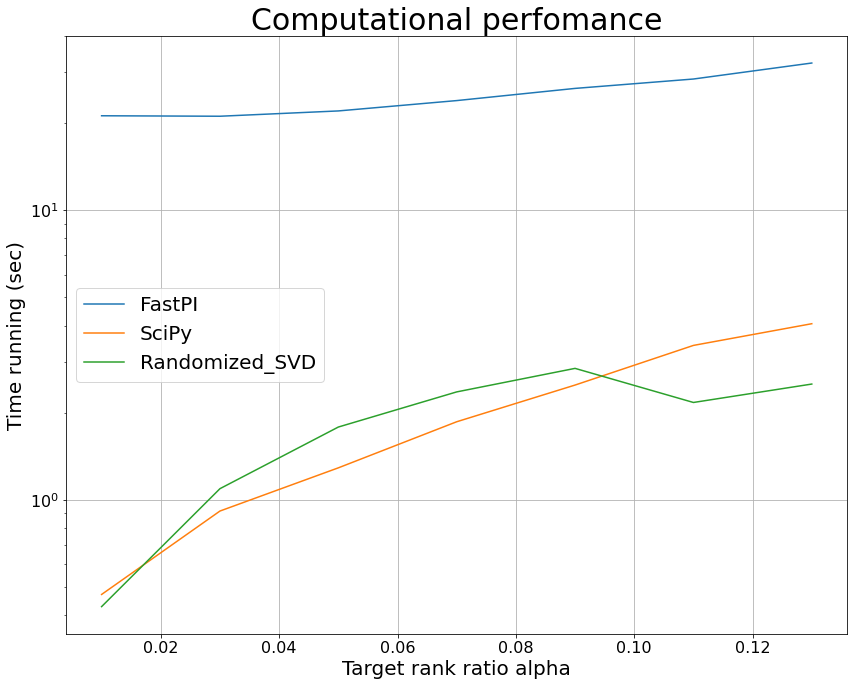

In [ ]:
#Plot of computational perfomance
fig, ax = plt.subplots(figsize = (14, 11))

plt.plot(np.arange(0.01, 0.15, 0.02), time, label='FastPI')
plt.plot(np.arange(0.01, 0.15, 0.02), time_M, label='SciPy')
plt.plot(np.arange(0.01, 0.15, 0.02), time_R, label='Randomized_SVD')


ax.set_xlabel('Target rank ratio alpha', fontsize=20)
plt.xticks(fontsize=16)

ax.set_ylabel('Time running (sec)', fontsize=20)
plt.yticks(fontsize=16)

plt.title('Computational perfomance', fontsize=30)
plt.yscale('log')
plt.legend(loc=6, prop={'size': 20})
plt.grid()
plt.show();

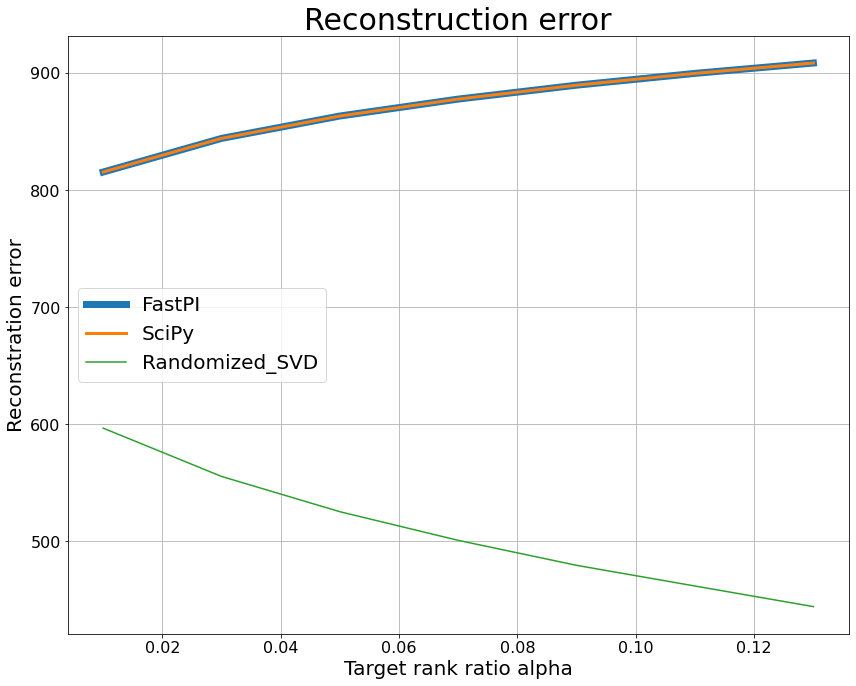

In [ ]:
#plot of reconstruction error
fig, ax = plt.subplots(figsize = (14, 11))

plt.plot(np.arange(0.01, 0.15, 0.02), error, label='FastPI', linewidth=7)
plt.plot(np.arange(0.01, 0.15, 0.02), error_M, label='SciPy', linewidth=3)
plt.plot(np.arange(0.01, 0.15, 0.02), error_R, label='Randomized_SVD')


ax.set_xlabel('Target rank ratio alpha', fontsize=20)
plt.xticks(fontsize=16)

ax.set_ylabel('Reconstration error', fontsize=20)
plt.yticks(fontsize=16)

plt.title('Reconstruction error', fontsize=30)
# plt.yscale('log')
plt.legend(loc=6, prop={'size': 20})
plt.grid()
plt.show();